In [1]:
from mcerp import N, umath, LogN, Gamma  # N, U, Gamma, Beta, correlate, etc.
import numpy as np
import locale
locale.setlocale(locale.LC_ALL, '') #this lets us put commas every three digits

#coefficients for Z=6 from Epperlein and Haines
Ap1=3.13
Ap0=1.80
ap1=6.29
ap0=2.79
gp1=3.49
g0=8.231
cp2=8.96
cp1=4.83
cp0=1.04
Bpp1=1.5
Bpp0=3.05
bpp2=7.83
bpp1=3.48
bpp0=0.718

#useful function tht really should be built in....rounds to n sig figs
round_to_n = lambda x, n: round(x, -int(np.floor(np.log10(np.abs(x)))) + (n - 1)) 

def str_nsf(x, n):
    #returns a string to n significant figures, and nicely formatted too!
    x_sig_figs=int(np.floor(np.log10(np.abs(x)))) #sig figs of x
    xsf=round_to_n(x,n)
    if xsf>=1:
        p=locale.format("%.0f",xsf, grouping=True)
    else:
        p=locale.format("%."+str(np.abs(x_sig_figs)+n-1)+"f",xsf, grouping=True)
    return p

class Plasma:
    #A is m_i/m_p, Z is effective nuclear charge, n_e in cm^-3, T, T_e, T_i in eV, B in Tesla
    #V is a charateristic speed in cm/s, L is a length scale in cm
    def __init__(self, A, Z, n_e, T=None, T_e=None, T_i=None, B=None, V=None, L=None):
        self.T_e=T_e
        self.T_i=T_i
        self.A=A
        self.Z=Z
        self.n_e=n_e
        self.B=B
        self.V=V
        self.L=L
        self.params()
    def params(self):
        B=np.abs(self.B*1e4)#convert to gauss for cgs compatibility
        Z=self.Z
        A=self.A
        n_i=self.n_e/Z
        n_e=self.n_e
        T_i=self.T_i
        T_e=self.T_e
        V=np.abs(self.V)
        #Lots of definitions of the coloumb logarithm
        self.col_log_ee=23.5-log_mean(n_e**0.5*T_e**-1.25)-(1e-5+((log_mean(T_e)-2)**2)/16.0)**0.5
        self.col_log_ei=col_log_ei(T_e, n_e,Z)
        self.col_log_ii=23-log_mean(np.sqrt(2)*n_i**0.5*Z**3*T_i**-1.5)
        #frequencies
        self.nu_ei=2.91e-6*Z*n_e*self.col_log_ei*T_e**-1.5#electrons on ions
        self.nu_ie=4.80e-8*Z**4*A**-0.5*n_i*self.col_log_ei*T_i**-1.5 #ions on electrons
        self.om_ce=1.76e7*B
        self.om_ci=9.58e3*B*Z/A
        self.om_pe=5.64e4*n_e**0.5
        self.om_pi=1.32e3*Z*A**-0.5*n_i**0.5
        m_i=A*1.66e-24#grams
        m_e=9.11e-28#grams
        self.nu_eq=1.8e-19*(m_i*m_e)**0.5*Z**2*n_e*self.col_log_ei/(m_i*T_e+m_e*T_i)**1.5
        self.tau_e=1/self.nu_eq
        #velocities
        self.V_te=4.19e7*T_e**0.5
        self.V_ti=9.79e5*A**-0.5*T_i**0.5
        self.V_S=9.79e5*A**-0.5*(Z*T_e+T_i)**0.5
        self.V_A=2.18e11*A**-0.5*n_i**-0.5*B
        #length scales
        self.la_de=7.43e2*T_e**0.5*n_e**-0.5
        self.delta_i=3e10/self.om_pi#ion skin depth
        self.delta_e=3e10/self.om_pe#electron skin depth
        self.rho_i=self.V_ti/self.om_ci#cm
        self.rho_e=self.V_te/self.om_ce#cm
        self.mfp_i=self.V_ti/self.nu_ie#cm
        self.mfp_e=self.V_te/self.nu_ei#cm
        #other
        self.eta_perp=1.03e-2*self.Z*self.col_log_ei*self.T_e**-1.5 #Ohm cm
        self.sigma_par=0.028*n_e/self.nu_ei#this could be in SI. Probably check before using elsewhere...
        self.KE=0.5*m_i*self.V**2*1e-7/1.6e-19#convert to SI (1e-7 ergs) and then to eV (1.6e-19)
        self.KE_Therm=self.KE/1.5
        #dimensionless parameters
        self.beta=2.03e-11*(n_e*T_e+n_i*T_i)/B**2#note coefficient is half of NRL as we have Z=/=1
        self.beta_kin=(2*np.pi*A*1.67e-24*n_i*self.V**2)/(B**2)#CGS formulation
        self.i_mag=self.om_ci/self.nu_ie
        self.e_mag=self.om_ce/self.nu_ei
        self.Rm_old=4e-11*np.pi*self.V*self.L*self.sigma_par#mu_0*sigma*V*L in SI, so some CGS->SI conversion here 
        self.Rm=1e2*4e-11*np.pi*self.V*self.L/self.eta_perp#mu_0*V*L/eta_perp in SI, so some CGS->SI conversion here 
        self.Al=self.V_A/self.V #Alfven number
        self.S=self.Al*self.Rm #Lundquist number
        chi=self.e_mag #this makes life easier for the next equation
        self.kappa_c_perp=(gp1*chi+g0)/(chi**3+cp2*chi**2+cp1*chi*cp0)#Epperlein and Haines
        self.H=self.kappa_c_perp*self.beta*self.e_mag/5.0#Haines number, Hall/Nernst, Joglekar 2014
        self.S_N=self.H*self.e_mag #Lundquist Nernst number #Joglekar 2014
        self.M_s=V/self.V_S
        self.M_a=V/self.V_A
    def print_dim_params(self):
        im='Ion magnetisation = '+str(round_to_n(self.i_mag,2))
        em='Electron magnetisation = '+str(round_to_n(self.e_mag,2))
        b='Thermal Beta = '+str(round_to_n(self.beta,2))
        br='Kinetic Beta = '+str(round_to_n(self.beta_kin,2))
        rm='Magnetic Reynolds Number = '+str(round_to_n(self.Rm,2))
        S='Lundquist number = '+str(round_to_n(self.S,2))
        H='Haines number = '+str(round_to_n(self.H,2))
        m='Mach number = '+str(round_to_n(self.M_s,2))
        ma='Mach-Alfven number = '+str(round_to_n(self.M_a,2))

        txtstr=im+'\n'+em+'\n'+b+'\n'+br+'\n'+m+'\n'+ma+'\n'+rm+'\n'+S+'\n'+H
        print txtstr

def col_log_ei(T_e,n_e,Z):
    if T_e<10*Z**2: #see NRL formulary pg 34
        col_log=23-log_mean(n_e**0.5*Z*T_e**-1.5)
    else:
        col_log=24-log_mean(n_e**0.5*T_e**-1.0)
    return col_log

def log_mean(X):
    return np.log(X.mean)

def Gamma_mu_sig(mu,sig):
    k=mu**2/sig
    theta=sig/mu
    return Gamma(k, theta)

ImportError: No module named PySide

In [33]:
p_p={'A':12,'Z':4,'n_e':N(6e17, 0.5e17),'T_e': Gamma(10, 8),'T_i':N(500, 20),'B': N(6, 1), 'V':N(6e5,1e5),'L':1.0}
plas=Plasma(**p_p)
plas.e_mag

uv(15.0317501628, 61.0177386599, 1.31119359429, 5.97138148518)

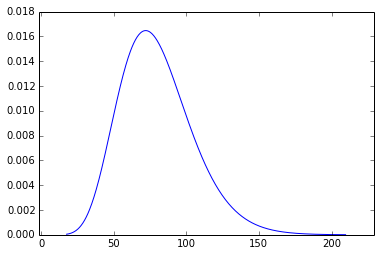

In [32]:
%matplotlib inline
Gamma_mu_sig(10, 8).plot()